In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
import joblib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import seaborn as sns


In [18]:
data = pd.read_csv('processed_data_by_property.csv')

In [19]:
categorical_features = ['TYPE', 'ZIPCODE', 'BOROUGH_x', 'NEIGHBORHOOD', 'IncomeCategory', 'PopulationDensityCategory']
numeric_features = [
    'BEDS', 'BATH', 'PROPERTYSQFT', 'PRICE_PER_SQFT',
    'Population', 'PopulationDensity', 'MedianHouseholdIncome', 'DiversityIndex',
    'FamilyHousehold', 'SingleHousehold', 'TotalBusinesses',
    'SafetyScore', 'QuietScore', 'FamilyFriendlinessScore',
    'BusinessEnvironmentScore', 'LivelinessScore', 'AmenityScore'
]

In [20]:
X = data[categorical_features + numeric_features]
y = data['PRICE']

In [21]:
# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [22]:
# Create a pipeline with preprocessor and model
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [23]:
# Split the data and train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['BEDS', 'BATH',
                                                   'PROPERTYSQFT',
                                                   'PRICE_PER_SQFT',
                                                   'Population',
                                                   'PopulationDensity',
                                                   'MedianHouseholdIncome',
                                                   'DiversityIndex',
                                                   'FamilyHousehold',
                                                   'SingleHousehold',
                                                   'TotalBusinesses',
                                                   'SafetyScore', 'QuietScore',
                                                   'FamilyFriendlinessScore',
                                                   'BusinessEnvironmentScore',
                                                   'LivelinessScore',
                                                   'AmenityScore']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['TYPE', 'ZIPCODE',
                                                   'BOROUGH_x', 'NEIGHBORHOOD',
                                                   'IncomeCategory',
                                                   'PopulationDensityCategory'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [24]:
# Calculate performance metrics
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Calculate MAE as a percentage
avg_train_price = y_train.mean()
avg_test_price = y_test.mean()
train_mae_percent = (train_mae / avg_train_price) * 100
test_mae_percent = (test_mae / avg_test_price) * 100

print("Model Performance:")
print(f"Training R2 Score: {train_r2:.4f}")
print(f"Testing R2 Score: {test_r2:.4f}")
print(f"Training MAE: ${train_mae:,.2f} ({train_mae_percent:.2f}%)")
print(f"Testing MAE: ${test_mae:,.2f} ({test_mae_percent:.2f}%)")

Model Performance:
Training R2 Score: 0.9984
Testing R2 Score: 0.9915
Training MAE: $9,447.41 (1.07%)
Testing MAE: $24,141.83 (2.55%)


In [25]:
# Save the model
joblib.dump(rf_model, 'rf_model_updated.joblib')

['rf_model_updated.joblib']

In [26]:
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R2 Scores: {cv_scores}")
print(f"Mean CV R2 Score: {np.mean(cv_scores)}")

Cross-Validation R2 Scores: [0.98115194 0.99262132 0.98841525 0.99051357 0.98228429]
Mean CV R2 Score: 0.9869972731531288


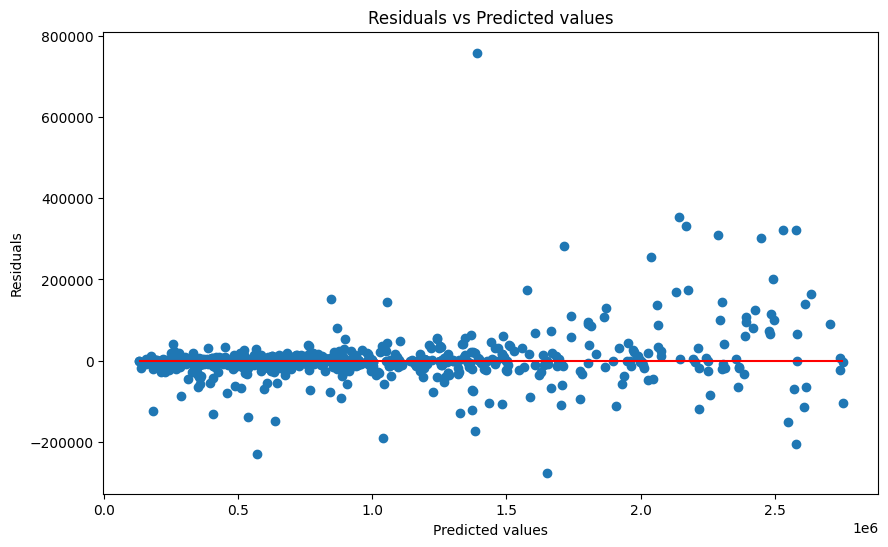

In [27]:
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals)
plt.hlines(y=0, xmin=y_test_pred.min(), xmax=y_test_pred.max(), colors='r')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values')
plt.show()

In [28]:
baseline_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
baseline_model.fit(X_train, y_train)
y_test_baseline_pred = baseline_model.predict(X_test)
baseline_r2 = r2_score(y_test, y_test_baseline_pred)
print(f"Baseline Linear Regression R2 Score: {baseline_r2:.4f}")

Baseline Linear Regression R2 Score: 0.8434


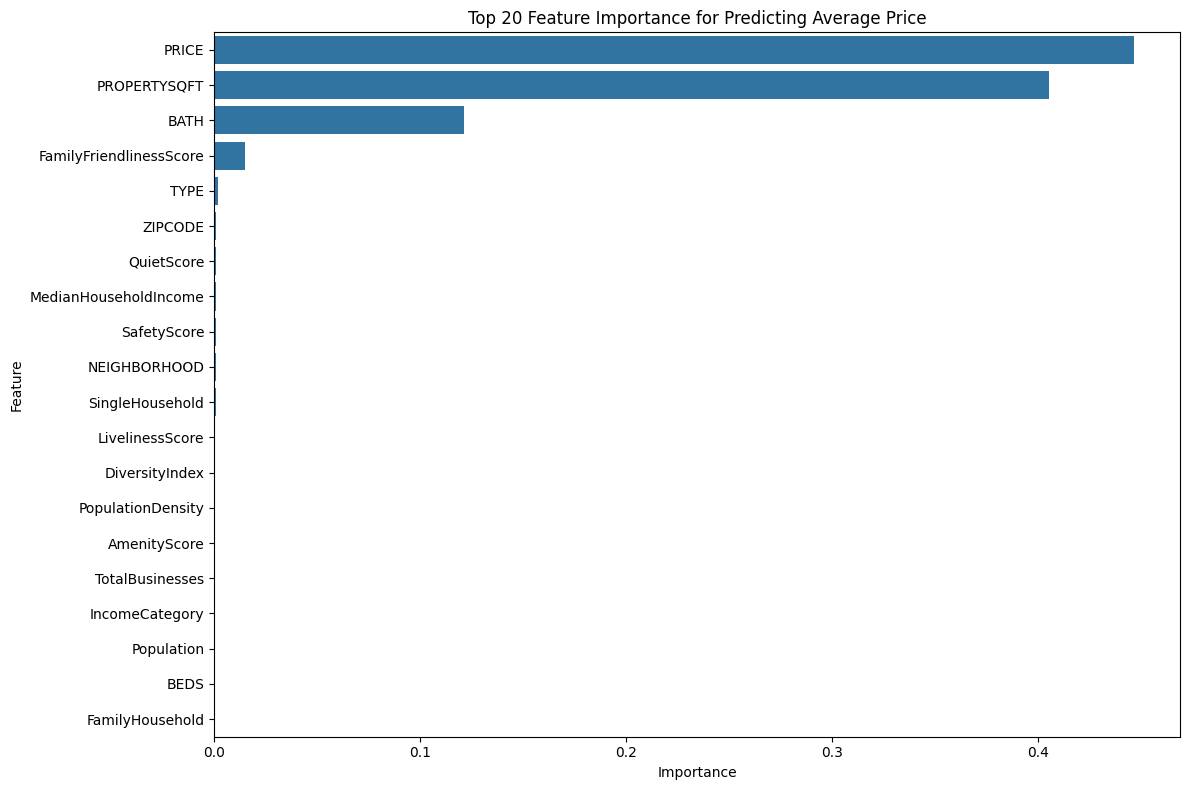

In [41]:
# Get feature names
numeric_features_names = numeric_features
categorical_features_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.array(numeric_features_names + list(categorical_features_names))

# Get feature importances from the random forest model
importances = rf_model.named_steps['regressor'].feature_importances_

# Aggregate importances for categorical variables
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance['feature'] = feature_importance['feature'].apply(lambda x: x.split('_')[0] if '_' in x else x)
feature_importance = feature_importance.groupby('feature').sum().reset_index()
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Plot top 20 feature importances
top_n = 20
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(top_n))
plt.title('Top 20 Feature Importance for Predicting Average Price')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [42]:
# Print feature importances
print("Feature Importances:")
print(feature_importance)

Feature Importances:
                      feature  importance
12                      PRICE    0.446637
13               PROPERTYSQFT    0.405446
1                        BATH    0.121226
6     FamilyFriendlinessScore    0.014844
20                       TYPE    0.002057
22                    ZIPCODE    0.000898
17                 QuietScore    0.000871
10      MedianHouseholdIncome    0.000819
18                SafetyScore    0.000786
11               NEIGHBORHOOD    0.000778
19            SingleHousehold    0.000728
9             LivelinessScore    0.000690
5              DiversityIndex    0.000662
15          PopulationDensity    0.000479
0                AmenityScore    0.000464
21            TotalBusinesses    0.000456
8              IncomeCategory    0.000392
14                 Population    0.000377
2                        BEDS    0.000375
7             FamilyHousehold    0.000352
16  PopulationDensityCategory    0.000253
3                     BOROUGH    0.000208
4    Business

## Test Query to see performance - poor performance

In [48]:
# Function to query the model and return top 5 zip codes by predicted price
def get_top_zipcodes(borough, max_price, house_type, bedrooms, bathrooms, sqft, model, data):
    # Prepare input data for prediction
    input_data = data.copy()
    input_data['BOROUGH_x'] = borough
    input_data['TYPE'] = house_type
    input_data['BEDS'] = bedrooms
    input_data['BATH'] = bathrooms
    input_data['PROPERTYSQFT'] = sqft
    input_data['PRICE_PER_SQFT'] = sqft / input_data['PROPERTYSQFT']  
    input_data = input_data[categorical_features + numeric_features]

    # Predict prices
    predicted_prices = model.predict(input_data)
    input_data['PredictedPrice'] = predicted_prices

    # Filter and sort by price
    filtered_data = input_data[input_data['PredictedPrice'] <= max_price]
    top_zipcodes = filtered_data[['ZIPCODE', 'PredictedPrice']].drop_duplicates().nlargest(5, 'PredictedPrice')
    
    return top_zipcodes

# Example query
query_params = {
    'borough': 'Brooklyn',
    'max_price': 1000000,
    'house_type': 'House',
    'bedrooms': 2,
    'bathrooms': 1,
    'sqft': 1000,
}

top_zipcodes = get_top_zipcodes(
    borough=query_params['borough'],
    max_price=query_params['max_price'],
    house_type=query_params['house_type'],
    bedrooms=query_params['bedrooms'],
    bathrooms=query_params['bathrooms'],
    sqft=query_params['sqft'],
    model=rf_model,
    data=data
)

print("Top 5 zip codes by predicted price:")
print(top_zipcodes)

Top 5 zip codes by predicted price:
     ZIPCODE  PredictedPrice
193  11415.0       252805.61
35   11211.0       248107.91
125  11694.0       247891.42
57   10002.0       247775.90
18   11375.0       246330.68
